# Downloading and Plotting River Gauge Data
## Written By Jared Rennie (@jjrennie)

Taps into APIs to get river gauge data and metadata. Two public API's are used. The first is the National Weather Service's <a href='https://water.noaa.gov' target="_blank">National Water Prediction System (NWPS)</a>, and the second is the US Geological Survey's <a href='https://waterdata.usgs.gov/nwis?' target='_blank'>National Water Information System (NWIS)</a>. Note that data in NWPS is only for the last 30 days, so NWIS is also used to get historical data.

- NWPS API Documentation: https://api.water.noaa.gov/nwps/v1/docs/#/Gauges/Gauges_ListGauges
- NWIS API Documentation: https://waterservices.usgs.gov/

### What You Need

First off, the entire codebase works in Python 3. In addition to base Python, you will need the following packages installed: 
- <a href='https://github.com/DOI-USGS/dataretrieval-python' target="_blank">dataretrieval-python</a> (aquire data from nwis)
- pandas and numpy (to slice and dice the data)
- matplotlib and cartopy (to plot the data)
    
The "easiest" way is to install these is by installing <a href='https://www.anaconda.com' target="_blank">anaconda</a>, and then applying <a href='https://conda-forge.org/' target="_blank">conda-forge</a>. Afterward, then you can install the above packages. 

### Importing Packages
Assuming you did the above, it should (in theory) import everything no problem:

In [2]:
# Import Packages
%matplotlib inline
import json,requests,sys,datetime,pytz
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

from dataretrieval import nwis

print("SUCCESS!")

SUCCESS!


If you made it this far, great! 

## Get Metadata from NWPS API
The metadata provided in the National Weather Service API (NWPS) has additional metadata features not provided elsewhere, including categorical flooding information, and historical crest information. So we will start there.

We need a station identifier to start, you can find stations by going to https://water.noaa.gov and picking a station. We will use a station in Fletcher, North Carolina (FLCN7) as an example.

And finally we need to give you credit for the images that are created later on!

In [3]:
# Input Arguments Here
stationID='FLCN7' 
author='Not Jared Rennie' 

The next block of code will grab the metadata from the API. The request comes out as JSON, so some parsing is needed. Also for some stations, historic crest data is not available, so we have to account for this.

In [3]:
# API URL (Metadata)
url = "https://api.water.noaa.gov/nwps/v1/gauges/"+stationID

# Make the request
response = requests.get(url)

# Check if request was successful
if response.status_code == 200:
    jsonData = response.json()  # Convert response to JSON

    # Record Time and Record Val might not be availale, so do a quick check here
    recordTime='-9999'
    recordVal=-9999.
    try:
        recordTime=jsonData["flood"]["crests"]["historic"][0].get("occurredTime")
        recordVal=jsonData["flood"]["crests"]["historic"][0].get("stage")
    except:
        pass
    
    # Extract relevant fields
    extracted_data = {
        # Metadata
        "NWS ID": jsonData.get("lid"),
        "USGS_ID": jsonData.get("usgsId"),
        "Name": jsonData.get("name"),
        "State": jsonData["state"].get("abbreviation") if "state" in jsonData else None,
        "Latitude": jsonData.get("latitude"),
        "Longitude": jsonData.get("longitude"),
        "TimeZone": jsonData.get("timeZone"),
        "RFC": jsonData["rfc"].get("abbreviation") if "rfc" in jsonData else None,
        "WFO": jsonData["wfo"].get("abbreviation") if "wfo" in jsonData else None,
        
        # Flood Stage Categories
        "Action": jsonData["flood"]["categories"]["action"].get("stage") if "flood" in jsonData else None,
        "Minor": jsonData["flood"]["categories"]["minor"].get("stage") if "flood" in jsonData else None,
        "Moderate": jsonData["flood"]["categories"]["moderate"].get("stage") if "flood" in jsonData else None,
        "Major": jsonData["flood"]["categories"]["major"].get("stage") if "flood" in jsonData else None,

        # Record Value
        "Record Time": recordTime,
        "Record Val": recordVal,
    }
    # Convert to DataFrame
    stnMeta = pd.DataFrame([extracted_data])  # Wrap in a list to create a single-row DataFrame
else:
    print(f"API Error: {response.status_code}")
stnMeta

NWS ID   USGS_ID                                               Name State  \
0  FLCN7  03447687  French Broad River at Old Fanning Bridge Rd, 3...    NC   

    Latitude  Longitude TimeZone    RFC  WFO  Action  Minor  Moderate  Major  \
0  35.429167   -82.5525  EST5EDT  LMRFC  GSP      10     13        17     20   

            Record Time  Record Val  
0  2024-09-27T22:15:00Z       30.61

Next we parse out specific metadata information we need for future analysis/plotting. Also note that the data we get is in UTC time, so we will need to take care of that so it matches current time zone.

In [4]:
# Get Some General Metadata
stationIDusgs=stnMeta['USGS_ID'].values[0]
stationIDnws=stnMeta['NWS ID'].values[0]
stationName=stnMeta['Name'].values[0]
stationState=stnMeta['State'].values[0]
sationNameFull=stationName+', '+stationState
print(sationNameFull)

# Get Time Zone Info (needed later)
tz_names = {
    "EST5EDT": "Eastern Time",  
    "CST6CDT": "Central Time",  
    "MST7MDT": "Mountain Time", 
    "PST8PDT": "Pacific Time" , 
    "HST10HDT": "Hawaii Time",  
    "HST10": "Hawaii Time",  
    "AKST9AKDT": "Alaska Time", 
    "AST9ADT": "Alaska Time", 
    "AST4": "Puerto Rico Time", 
    "GMT0GMT": "UTC Time"
}
stnTZName1=stnMeta['TimeZone'].values[0]
stnTZName2= tz_names.get(stnTZName1, "Unknown")
print(stnTZName1,stnTZName2)
if stnTZName1 == 'AKST9AKDT' or stnTZName1 == 'AST9ADT':
    convertTZ='US/Alaska'
elif stnTZName1 == 'HST10HDT' or stnTZName1 == 'HST10':
    convertTZ='US/Hawaii'
else:
    convertTZ=stnTZName1

# Get Flood Stages
hasAction=hasMinor=hasModerate=hasMajor=False
stationAction=stnMeta['Action'].values[0]
stationMinor=stnMeta['Minor'].values[0]
stationModerate=stnMeta['Moderate'].values[0]
stationMajor=stnMeta['Major'].values[0]
if stationAction > -9999:
    hasAction=True
if stationMinor > -9999:
    hasMinor=True
if stationModerate > -9999:
    hasModerate=True
if stationMajor > -9999:
    hasMajor=True
print(stationAction,stationMinor,stationModerate,stationMajor)

# Get Record 
stationRecordVal=-9999
stationRecordDate=-9999
stationRecordDate2=-9999
hasRecord=False
if stnMeta['Record Val'].values[0] > -9999:
    hasRecord=True
    stationRecordVal=stnMeta['Record Val'].values[0]
    stationRecordDate=stnMeta['Record Time'].values[0]
    stationRecordDate2 = pd.to_datetime(stationRecordDate).tz_convert(convertTZ).strftime('%Y-%m-%d %H:%M')
print(stationRecordVal,stationRecordDate,stationRecordDate2)

French Broad River at Old Fanning Bridge Rd, 3 W Fletcher, NC
EST5EDT Eastern Time
10 13 17 20
30.61 2024-09-27T22:15:00Z 2024-09-27 18:15


## Get Observed Data

This block of code will get the latest observational river gauge height data for this station. Note that the data comes in UTC, so we will add a new column that indicates local time.

In [5]:
# API URL (Observed Data)
url='https://api.water.noaa.gov/nwps/v1/gauges/'+str(stationID)+'/stageflow/observed'

# Make the request
response = requests.get(url)

# Check if request was successful
if response.status_code == 200:
    stnData = response.json()  # Convert response to JSON
    
    # Convert Data to Pandas DF
    outDataObs = pd.DataFrame(stnData["data"])[["validTime", "primary"]]
    outDataObs["validTimeUTC"] = pd.to_datetime(outDataObs["validTime"])
    
    # Get Stats (Observed)
    outDataObs=outDataObs[outDataObs['primary'] >= -990]
    dataObsMax="%.2f" % (outDataObs['primary'].max())
    dataObsMin="%.2f" % (outDataObs['primary'].min())
    if convertTZ == 'GMT0GMT' or convertTZ =='UTC':
        outDataObs["validTimeLocal"]=outDataObs["validTimeUTC"]
    else:
        outDataObs["validTimeLocal"] = pd.to_datetime(outDataObs["validTime"]).dt.tz_convert(convertTZ)
    outDataObs['Type']='O'
else:
    print(f"Error: {response.status_code}")

# Get Current Time
currTime = datetime.datetime.now(pytz.utc)
currTime = pd.to_datetime(currTime).strftime('%Y%m%d-%H%MUTC')
outDataObs

validTime  primary              validTimeUTC  \
0     2025-02-28T18:15:00Z     5.26 2025-02-28 18:15:00+00:00   
1     2025-02-28T18:30:00Z     5.26 2025-02-28 18:30:00+00:00   
2     2025-02-28T18:45:00Z     5.26 2025-02-28 18:45:00+00:00   
3     2025-02-28T19:00:00Z     5.25 2025-02-28 19:00:00+00:00   
4     2025-02-28T19:15:00Z     5.26 2025-02-28 19:15:00+00:00   
...                    ...      ...                       ...   
2866  2025-03-30T16:30:00Z     4.79 2025-03-30 16:30:00+00:00   
2867  2025-03-30T16:45:00Z     4.79 2025-03-30 16:45:00+00:00   
2868  2025-03-30T17:00:00Z     4.79 2025-03-30 17:00:00+00:00   
2869  2025-03-30T17:15:00Z     4.79 2025-03-30 17:15:00+00:00   
2870  2025-03-30T17:30:00Z     4.79 2025-03-30 17:30:00+00:00   

                validTimeLocal Type  
0    2025-02-28 13:15:00-05:00    O  
1    2025-02-28 13:30:00-05:00    O  
2    2025-02-28 13:45:00-05:00    O  
3    2025-02-28 14:00:00-05:00    O  
4    2025-02-28 14:15:00-05:00    O  
...                        ...  ...  
2866 2025-03-30 12:30:00-04:00    O  
2867 2025-03-30 12:45:00-04:00    O  
2868 2025-03-30 13:00:00-04:00    O  
2869 2025-03-30 13:15:00-04:00    O  
2870 2025-03-30 13:30:00-04:00    O  

[2871 rows x 5 columns]

## Get Forecast Data

NWPS also has data from the [National Water Model](https://water.noaa.gov/about/nwm) (not available at all stations) so let's get that if it is available.

In [6]:
# API URL (Forecast Data)
url='https://api.water.noaa.gov/nwps/v1/gauges/'+str(stationID)+'/stageflow/forecast'

# Make the request
response = requests.get(url)

# Check if request was successful
if response.status_code == 200:
    try:
        stnData = response.json()  # Convert response to JSON
    
        # Convert Data to Pandas DF
        outDataFcst = pd.DataFrame(stnData["data"])[["validTime", "primary"]]
        outDataFcst["validTimeUTC"] = pd.to_datetime(outDataFcst["validTime"])
        
        # Get Stats (Forecast)
        outDataFcst=outDataFcst[outDataFcst['primary'] >= -990]
        dataFcstMax="%.2f" % (outDataFcst['primary'].max())
        dataFcstMin="%.2f" % (outDataFcst['primary'].min())
        if convertTZ == 'GMT0GMT' or convertTZ =='UTC':
            outDataFcst["validTimeLocal"]=outDataFcst["validTimeUTC"]
        else:
            outDataFcst["validTimeLocal"] = pd.to_datetime(outDataFcst["validTime"]).dt.tz_convert(convertTZ)
        outDataFcst['Type']='F'
    except:
        print('NO FCST DATA')
        outDataFcst=dataFcstMax=dataFcstMin=-9999
else:
    print(f"Error: {response.status_code}")
    outDataFcst=-9999
outDataFcst

validTime  primary              validTimeUTC  \
0   2025-03-30T18:00:00Z      4.8 2025-03-30 18:00:00+00:00   
1   2025-03-31T00:00:00Z      4.9 2025-03-31 00:00:00+00:00   
2   2025-03-31T06:00:00Z      5.0 2025-03-31 06:00:00+00:00   
3   2025-03-31T12:00:00Z      5.1 2025-03-31 12:00:00+00:00   
4   2025-03-31T18:00:00Z      5.1 2025-03-31 18:00:00+00:00   
5   2025-04-01T00:00:00Z      5.2 2025-04-01 00:00:00+00:00   
6   2025-04-01T06:00:00Z      5.2 2025-04-01 06:00:00+00:00   
7   2025-04-01T12:00:00Z      5.1 2025-04-01 12:00:00+00:00   
8   2025-04-01T18:00:00Z      5.0 2025-04-01 18:00:00+00:00   
9   2025-04-02T00:00:00Z      4.9 2025-04-02 00:00:00+00:00   
10  2025-04-02T06:00:00Z      4.9 2025-04-02 06:00:00+00:00   
11  2025-04-02T12:00:00Z      4.9 2025-04-02 12:00:00+00:00   
12  2025-04-02T18:00:00Z      4.8 2025-04-02 18:00:00+00:00   
13  2025-04-03T00:00:00Z      4.8 2025-04-03 00:00:00+00:00   
14  2025-04-03T06:00:00Z      4.8 2025-04-03 06:00:00+00:00   
15  2025-04-03T12:00:00Z      4.8 2025-04-03 12:00:00+00:00   
16  2025-04-03T18:00:00Z      4.7 2025-04-03 18:00:00+00:00   
17  2025-04-04T00:00:00Z      4.7 2025-04-04 00:00:00+00:00   
18  2025-04-04T06:00:00Z      4.7 2025-04-04 06:00:00+00:00   
19  2025-04-04T12:00:00Z      4.7 2025-04-04 12:00:00+00:00   

              validTimeLocal Type  
0  2025-03-30 14:00:00-04:00    F  
1  2025-03-30 20:00:00-04:00    F  
2  2025-03-31 02:00:00-04:00    F  
3  2025-03-31 08:00:00-04:00    F  
4  2025-03-31 14:00:00-04:00    F  
5  2025-03-31 20:00:00-04:00    F  
6  2025-04-01 02:00:00-04:00    F  
7  2025-04-01 08:00:00-04:00    F  
8  2025-04-01 14:00:00-04:00    F  
9  2025-04-01 20:00:00-04:00    F  
10 2025-04-02 02:00:00-04:00    F  
11 2025-04-02 08:00:00-04:00    F  
12 2025-04-02 14:00:00-04:00    F  
13 2025-04-02 20:00:00-04:00    F  
14 2025-04-03 02:00:00-04:00    F  
15 2025-04-03 08:00:00-04:00    F  
16 2025-04-03 14:00:00-04:00    F  
17 2025-04-03 20:00:00-04:00    F  
18 2025-04-04 02:00:00-04:00    F  
19 2025-04-04 08:00:00-04:00    F

Combine observed and forecast data (if exists). This will also help us with plotting later.

In [7]:
hasFcst=False
# Combine Obs and Forecast
if type(outDataFcst) != int:
    outData=pd.concat([outDataObs,outDataFcst],ignore_index=True)
    hasFcst=True
else:
    outData=outDataObs
outData

validTime  primary              validTimeUTC  \
0     2025-02-28T18:15:00Z     5.26 2025-02-28 18:15:00+00:00   
1     2025-02-28T18:30:00Z     5.26 2025-02-28 18:30:00+00:00   
2     2025-02-28T18:45:00Z     5.26 2025-02-28 18:45:00+00:00   
3     2025-02-28T19:00:00Z     5.25 2025-02-28 19:00:00+00:00   
4     2025-02-28T19:15:00Z     5.26 2025-02-28 19:15:00+00:00   
...                    ...      ...                       ...   
2886  2025-04-03T12:00:00Z     4.80 2025-04-03 12:00:00+00:00   
2887  2025-04-03T18:00:00Z     4.70 2025-04-03 18:00:00+00:00   
2888  2025-04-04T00:00:00Z     4.70 2025-04-04 00:00:00+00:00   
2889  2025-04-04T06:00:00Z     4.70 2025-04-04 06:00:00+00:00   
2890  2025-04-04T12:00:00Z     4.70 2025-04-04 12:00:00+00:00   

                validTimeLocal Type  
0    2025-02-28 13:15:00-05:00    O  
1    2025-02-28 13:30:00-05:00    O  
2    2025-02-28 13:45:00-05:00    O  
3    2025-02-28 14:00:00-05:00    O  
4    2025-02-28 14:15:00-05:00    O  
...                        ...  ...  
2886 2025-04-03 08:00:00-04:00    F  
2887 2025-04-03 14:00:00-04:00    F  
2888 2025-04-03 20:00:00-04:00    F  
2889 2025-04-04 02:00:00-04:00    F  
2890 2025-04-04 08:00:00-04:00    F  

[2891 rows x 5 columns]

### Output to CSV
Let's output the data to a CSV file so you can load it and play with it elsewhere. Or you can keep playing with it here. You do you!

In [8]:
# Output to CSV
csvFile='nwps_gauge_'+str(stationID)+'_'+currTime+'.csv'
outData.to_csv(csvFile,index = False)
print('OUTPUTTING TO CSV: ',csvFile)

OUTPUTTING TO CSV:  nwps_gauge_FLCN7_20250330-1903UTC.csv


Are you ready for the fun part? Cause here comes the fun part!

## Plot Hydrograph
Feel free to play with the plotting parameters below if you wish. 

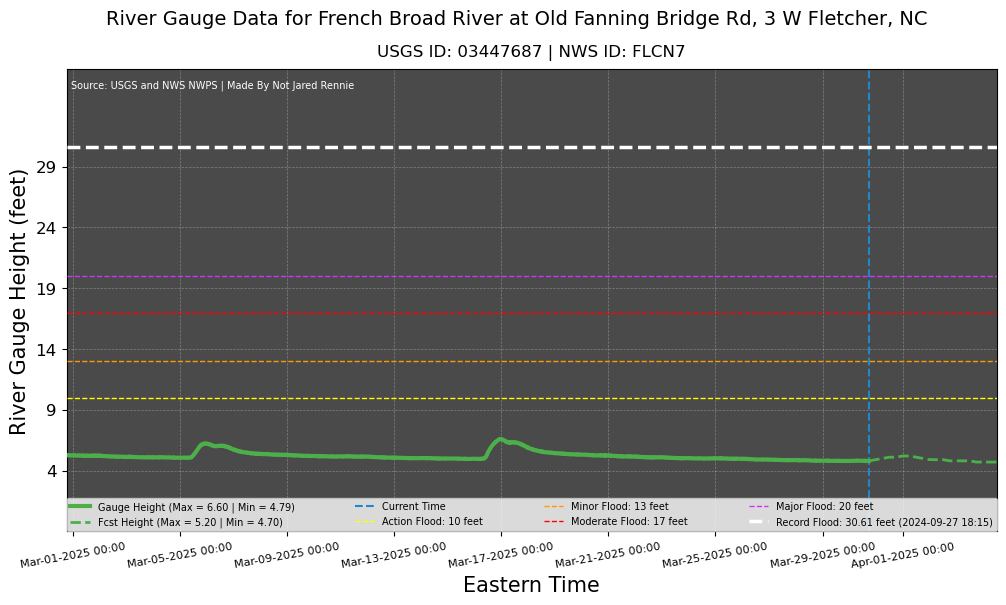

In [9]:
############################################################
# PLOT
dpi=100
fig, ax1 = plt.subplots(figsize=(12, 6), edgecolor='white', facecolor='white', dpi=dpi)

# Add grid lines
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
ax1.set_facecolor('#4a4a4a')

# Plot X Limits
xMin=outData['validTimeLocal'].values[0]
xMax=outData['validTimeLocal'].values[-1]

# Plot Y Limits
ymin=min(int(1 * round(float((min(outData['primary'].values) - 1))/1)),9999)
if hasRecord:
    ymax=max(int(1 * round(float((stationRecordVal + 1))/1)),-9999)
elif hasMajor:
    ymax=max(int(1 * round(float((stationMajor + 1))/1)),-9999)
elif hasModerate:
    ymax=max(int(1 * round(float((stationModerate + 1))/1)),-9999)
elif hasMinor:
    ymax=max(int(1 * round(float((stationMinor + 1))/1)),-9999)
elif hasAction:
    ymax=max(int(1 * round(float((stationAction + 1))/1)),-9999)
else:
    ymax=max(int(1 * round(float((max(outData['primary'].values) - 1))/1)),9999)
plt.ylim((ymin-5), (ymax+5))

# Plot Data
plt.plot(outDataObs['validTimeLocal'].values, outDataObs['primary'].values, linewidth=3, color='#4daf4a', label="Gauge Height (Max = "+str(dataObsMax)+" | Min = "+str(dataObsMin)+")",zorder=10)
if hasFcst:
    plt.plot(outDataFcst['validTimeLocal'].values, outDataFcst['primary'].values, linewidth=2,linestyle='dashed', color='#4daf4a', label="Fcst Height (Max = "+str(dataFcstMax)+" | Min = "+str(dataFcstMin)+")",zorder=10)
    plt.vlines(outDataFcst['validTimeLocal'].values[0],ymin-5,ymax+5,colors='#1d89cb',linewidth=1.5, linestyles='dashed',label='Current Time',zorder=9)

# Plot Flood Thresholds
if hasAction:
    plt.hlines(float(stationAction),xMin,xMax,colors='#feff03',linewidth=1, linestyles='dashed',label="Action Flood: "+str(stationAction)+' feet',zorder=9)
if hasMinor:
    plt.hlines(float(stationMinor),xMin,xMax,colors='#fe9804',linewidth=1, linestyles='dashed',label="Minor Flood: "+str(stationMinor)+' feet',zorder=9)
if hasModerate:
    plt.hlines(float(stationModerate),xMin,xMax,colors='#fe0200',linewidth=1, linestyles='dashed',label="Moderate Flood: "+str(stationModerate)+' feet',zorder=9)
if hasMajor:
    plt.hlines(float(stationMajor),xMin,xMax,colors='#cc33ff',linewidth=1, linestyles='dashed',label="Major Flood: "+str(stationMajor)+' feet',zorder=9)
if hasRecord:
    plt.hlines(float(stationRecordVal),xMin,xMax,colors='white',linewidth=2.5, linestyles='dashed',label="Record Flood: "+str(stationRecordVal)+' feet '+'('+(stationRecordDate2)+')',zorder=9)

# Plot Legend
plt.legend(loc=3, ncol=4, mode="expand", borderaxespad=0., fontsize=7).set_zorder(102)

# Plot Y-Axis Label
plt.yticks(range(ymin, ymax, 5), [r'{}'.format(x) for x in range(ymin, ymax, 5)], fontsize=12, color='black')
plt.ylabel(r'River Gauge Height (feet)', fontsize=15, color='black')

# Plot X Limits
plt.xlim(xMin, xMax)

# Plot X-Axis Label
dateFmt = mdates.DateFormatter('%b-%d-%Y %H:%M')
ax1.xaxis.set_major_formatter(dateFmt)
ax1.tick_params(axis='x', labelrotation=10,labelsize=8)
plt.xlabel(stnTZName2, fontsize=15, color='black')

# Plot Title/Subtitle
plt.suptitle('River Gauge Data for '+sationNameFull, fontsize=14, color='black')
plt.title('USGS ID: '+str(stationIDusgs)+' | NWS ID: '+str(stationIDnws),fontsize=12,color='black',y=1.01)
plt.annotate('Source: USGS and NWS NWPS | Made By '+author,xy=(0.005, 0.955), xycoords='axes fraction', fontsize=7,horizontalalignment='left', verticalalignment='bottom', color='white')

plt.show()

## Get Historical Data from USGS NWIS
This is great so far, but NWPS only has the last 30 days of data. What if we wanted to go farther back in time? Well that is where we go to the USGS API.

Here, we have to use the USGS ID, but the NWPS API already figure dout what it was, so use that. Also, we need to define a start and end date. Otherwise it may take the entire period of record, which could take time.

In [10]:
# Derine station (USGS ID needed here, but we already captured it)
site=stationIDusgs

# Define Start and End Date
startDate='2024-09-20'
endDate='2024-10-05'
print(site,startDate,endDate)

03447687 2024-09-20 2024-10-05


The NWIS API from USGS is slightly different, but we are using the 'dataretrieval' python package to do most of the heavy lifting. Here we want 'instantaneous values' of river gauge height (parameter number 00065). We also need to convert UTC time to Local Time.

In [11]:
# Get Data from NWIS API
inService='iv'    # iv = instantaneous values (sub hourly) | dv = daily values
parameter='00065' # River Gauge Height
stnData = nwis.get_record(sites=site,service=inService,start=startDate, end=endDate, parameterCd=parameter).reset_index()

# Get Stats
stnDataMax=stnData[parameter].max()
stnDataMin=stnData[parameter].min()

# Deal with Time Zones
stnData["validTimeUTC"] = pd.to_datetime(stnData["datetime"])
stnData["validTimeLocal"] = pd.to_datetime(stnData["datetime"]).dt.tz_convert(convertTZ)

stnData

datetime   site_no  00065 00065_cd  \
0    2024-09-20 04:00:00+00:00  03447687   4.54        P   
1    2024-09-20 04:15:00+00:00  03447687   4.54        P   
2    2024-09-20 04:30:00+00:00  03447687   4.54        P   
3    2024-09-20 04:45:00+00:00  03447687   4.53        P   
4    2024-09-20 05:00:00+00:00  03447687   4.53        P   
...                        ...       ...    ...      ...   
1531 2024-10-06 02:45:00+00:00  03447687   6.40        P   
1532 2024-10-06 03:00:00+00:00  03447687   6.39        P   
1533 2024-10-06 03:15:00+00:00  03447687   6.39        P   
1534 2024-10-06 03:30:00+00:00  03447687   6.38        P   
1535 2024-10-06 03:45:00+00:00  03447687   6.38        P   

                  validTimeUTC            validTimeLocal  
0    2024-09-20 04:00:00+00:00 2024-09-20 00:00:00-04:00  
1    2024-09-20 04:15:00+00:00 2024-09-20 00:15:00-04:00  
2    2024-09-20 04:30:00+00:00 2024-09-20 00:30:00-04:00  
3    2024-09-20 04:45:00+00:00 2024-09-20 00:45:00-04:00  
4    2024-09-20 05:00:00+00:00 2024-09-20 01:00:00-04:00  
...                        ...                       ...  
1531 2024-10-06 02:45:00+00:00 2024-10-05 22:45:00-04:00  
1532 2024-10-06 03:00:00+00:00 2024-10-05 23:00:00-04:00  
1533 2024-10-06 03:15:00+00:00 2024-10-05 23:15:00-04:00  
1534 2024-10-06 03:30:00+00:00 2024-10-05 23:30:00-04:00  
1535 2024-10-06 03:45:00+00:00 2024-10-05 23:45:00-04:00  

[1536 rows x 6 columns]

In [12]:
# Output to CSV
csvFile='nwps_gauge_'+str(stationID)+'_'+startDate.replace('-','')+'-'+endDate.replace('-','')+'.csv'
stnData.to_csv(csvFile,index = False)
print('OUTPUTTING TO CSV: ',csvFile)

OUTPUTTING TO CSV:  nwps_gauge_FLCN7_20240920-20241005.csv


Now we plot again (note that there is no forecast data here).

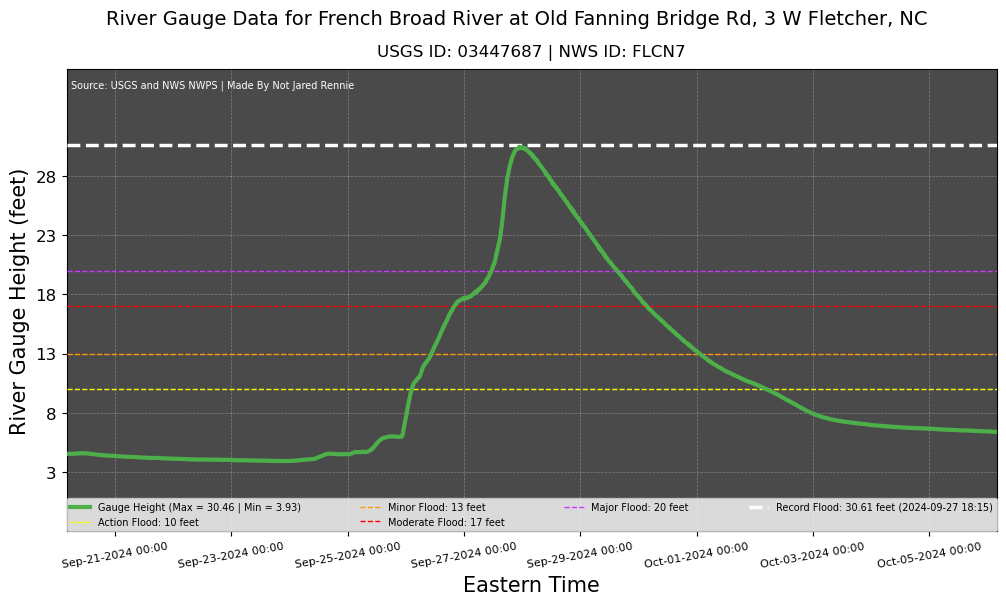

In [13]:
############################################################
# PLOT
dpi=100
fig, ax1 = plt.subplots(figsize=(12, 6), edgecolor='white', facecolor='white', dpi=dpi)

# Add grid lines
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
ax1.set_facecolor('#4a4a4a')

# Plot X Limits
xMin=stnData['validTimeLocal'].values[0]
xMax=stnData['validTimeLocal'].values[-1]

# Plot Y Limits
ymin=min(int(1 * round(float((min(stnData[parameter].values) - 1))/1)),9999)
if hasRecord:
    ymax=max(int(1 * round(float((stationRecordVal + 1))/1)),-9999)
elif hasMajor:
    ymax=max(int(1 * round(float((stationMajor + 1))/1)),-9999)
elif hasModerate:
    ymax=max(int(1 * round(float((stationModerate + 1))/1)),-9999)
elif hasMinor:
    ymax=max(int(1 * round(float((stationMinor + 1))/1)),-9999)
elif hasAction:
    ymax=max(int(1 * round(float((stationAction + 1))/1)),-9999)
else:
    ymax=max(int(1 * round(float((max(stnData[parameter].values) + 1))/1)),-9999)
plt.ylim((ymin-5), (ymax+5))

# Plot Data
plt.plot(stnData['validTimeLocal'].values, stnData[parameter].values, linewidth=3, color='#4daf4a', label="Gauge Height (Max = "+str(stnDataMax)+" | Min = "+str(stnDataMin)+")",zorder=10)

# Plot Flood Thresholds
if hasAction:
    plt.hlines(float(stationAction),xMin,xMax,colors='#feff03',linewidth=1, linestyles='dashed',label="Action Flood: "+str(stationAction)+' feet',zorder=9)
if hasMinor:
    plt.hlines(float(stationMinor),xMin,xMax,colors='#fe9804',linewidth=1, linestyles='dashed',label="Minor Flood: "+str(stationMinor)+' feet',zorder=9)
if hasModerate:
    plt.hlines(float(stationModerate),xMin,xMax,colors='#fe0200',linewidth=1, linestyles='dashed',label="Moderate Flood: "+str(stationModerate)+' feet',zorder=9)
if hasMajor:
    plt.hlines(float(stationMajor),xMin,xMax,colors='#cc33ff',linewidth=1, linestyles='dashed',label="Major Flood: "+str(stationMajor)+' feet',zorder=9)
if hasRecord:
    plt.hlines(float(stationRecordVal),xMin,xMax,colors='white',linewidth=2.5, linestyles='dashed',label="Record Flood: "+str(stationRecordVal)+' feet '+'('+(stationRecordDate2)+')',zorder=9)

# Plot Legend
plt.legend(loc=3, ncol=4, mode="expand", borderaxespad=0., fontsize=7).set_zorder(102)

# Plot Y-Axis Label
plt.yticks(range(ymin, ymax, 5), [r'{}'.format(x) for x in range(ymin, ymax, 5)], fontsize=12, color='black')
plt.ylabel(r'River Gauge Height (feet)', fontsize=15, color='black')

# Plot X Limits
plt.xlim(xMin, xMax)

# Plot X-Axis Label
dateFmt = mdates.DateFormatter('%b-%d-%Y %H:%M')
ax1.xaxis.set_major_formatter(dateFmt)
ax1.tick_params(axis='x', labelrotation=10,labelsize=8)
plt.xlabel(stnTZName2, fontsize=15, color='black')

# Plot Title/Subtitle
plt.suptitle('River Gauge Data for '+sationNameFull, fontsize=14, color='black')
plt.title('USGS ID: '+str(stationIDusgs)+' | NWS ID: '+str(stationIDnws),fontsize=12,color='black',y=1.01)
plt.annotate('Source: USGS and NWS NWPS | Made By '+author,xy=(0.005, 0.955), xycoords='axes fraction', fontsize=7,horizontalalignment='left', verticalalignment='bottom', color='white')

plt.show()

## Get Metadata and Data (Multiple Stations)
We now return to NWPS to get a snapshot of current flooding for the United States. First we have to gather stations for the US, including OCONUS areas such as Alaska, Hawaii, and Puerto Rico. Note that this is a big request to the API, and may take a couple of times before a successful grab.

If you continue to get API Errors, try and get a smaller subset of stations by changing the bounding box.

In [4]:
%%time
# Get Bounding Box
#xmin='-179.1'; ymin='17.9'; xmax='-65.2'; ymax='71.4'  # Entire US (including CONUS and AK/HI/PR)
#xmin='-125.0'; ymin='24.5'; xmax='-66.9'; ymax='49.4'  # Lower 48 States Only
xmin='-95.0'; ymin='24.5'; xmax='-73.0'; ymax='40.0'  # Southeast Subset

# API URL
url='https://api.water.noaa.gov/nwps/v1/gauges?bbox.xmin='+xmin+'&bbox.ymin='+ymin+'&bbox.xmax='+xmax+'&bbox.ymax='+ymax+'&srid=EPSG_4326'

# Make the request
response = requests.get(url)

# Check if request was successful
if response.status_code == 200:
    multData = response.json()  # Convert response to JSON
    print('SUCCESS!')
    print('NUM STNS: ',len(multData['gauges']))
else:
    print(f"API Error: {response.status_code}")

# Get Current Time
currTime = datetime.datetime.now(pytz.utc)
currTime = pd.to_datetime(currTime).strftime('%Y%m%d-%H%MUTC')
currTimeUTC = datetime.datetime.now(pytz.utc)
currTimeUTC= pd.to_datetime(currTimeUTC).strftime('%Y-%m-%d %H:%M UTC')

SUCCESS!
NUM STNS:  4167
CPU times: user 60.4 ms, sys: 13.9 ms, total: 74.3 ms
Wall time: 27.2 s


Parse out the relevant metadata/data info into a Pandas Dataframe

In [14]:
%%time

# Run Through Each Station
data_counter=0
for data in multData['gauges']:    
    # Extract relevant fields
    extracted_data = {
        # Metadata
        "NWS ID": data.get("lid"),
        "Name": data.get("name"),
        "State": data["state"].get("abbreviation") if "state" in data else None,
        "Latitude": data.get("latitude"),
        "Longitude": data.get("longitude"),
        "RFC": data["rfc"].get("abbreviation") if "rfc" in data else None,
        "WFO": data["wfo"].get("abbreviation") if "wfo" in data else None,
        
        # Flooding Info
        "Gauge Height": data["status"]["observed"].get("primary") if "status" in data else None,
        "Flood Info": data["status"]["observed"].get("floodCategory") if "status" in data else None,
        "Fcst Height": data["status"]["forecast"].get("primary") if "status" in data else None,
        "Fcst Info": data["status"]["forecast"].get("floodCategory") if "status" in data else None,
    }
    df = pd.DataFrame([extracted_data]) 
    if data_counter==0:
        outData = df
    else:
        outData = pd.concat([outData, df], ignore_index=True)
    data_counter+=1
outData

CPU times: user 4.22 s, sys: 0 ns, total: 4.22 s
Wall time: 4.22 s


NWS ID                                               Name State  \
0     AANG1                         Peachtree Creek at Atlanta    GA   
1     ABAG1    Alabaha River at GA Highway 203 near Blackshear    GA   
2     ABBG1                        Ocmulgee River at Abbeville    GA   
3     ABBN7                       Abbotts Creek near Lexington    NC   
4     ABBV2           Craig Creek at Broad Run near New Castle    VA   
...     ...                                                ...   ...   
4162  ZONI3                     Eagle Creek (IN) at Zionsville    IN   
4163  ZPHF1  Hillsborough River near Zephyrhills at State Park    FL   
4164  ZSRM2                      Zekiah Swamp Run near Newtown    MD   
4165  ZTNK2                      Pennsylvania Run near Zoneton    KY   
4166  ZUNV2                    Blackwater River (VA) near ZUNI    VA   

       Latitude  Longitude    RFC  WFO  Gauge Height   Flood Info  \
0     33.820306 -84.407639  SERFC  FFC          6.66  no_flooding   
1     31.375278 -82.288889  SERFC  JAX          5.92  no_flooding   
2     31.996667 -83.279167  SERFC  FFC          5.96  no_flooding   
3     35.806944 -80.234722  SERFC  RAH          4.03  no_flooding   
4     37.451517 -80.112736  MARFC  RNK          3.97  not_defined   
...         ...        ...    ...  ...           ...          ...   
4162  39.946389 -86.260278  OHRFC  IND          3.57  no_flooding   
4163  28.149722 -82.231944  SERFC  TBW          1.08  no_flooding   
4164  38.490556 -76.927222  MARFC  LWX          2.05  no_flooding   
4165  38.087500 -85.642500  OHRFC  LMK          2.04  not_defined   
4166  36.906389 -76.820278  SERFC  AKQ         18.01  no_flooding   

      Fcst Height         Fcst Info  
0          -999.0  fcst_not_current  
1          -999.0  fcst_not_current  
2            11.5            action  
3          -999.0  fcst_not_current  
4          -999.0  fcst_not_current  
...           ...               ...  
4162          3.3       no_flooding  
4163       -999.0  fcst_not_current  
4164       -999.0  fcst_not_current  
4165       -999.0  fcst_not_current  
4166       -999.0  fcst_not_current  

[4167 rows x 11 columns]

We only want current gauge info that is reporting properly. Some sites (for example, Alaska) don't operate year round.

In [15]:
# Only Use Current Stations Reporting
flood_categories=['no_flooding','action','minor','moderate','major']
outData=outData[outData['Flood Info'].isin(flood_categories)]

outData

NWS ID                                               Name State  \
0     AANG1                         Peachtree Creek at Atlanta    GA   
1     ABAG1    Alabaha River at GA Highway 203 near Blackshear    GA   
2     ABBG1                        Ocmulgee River at Abbeville    GA   
3     ABBN7                       Abbotts Creek near Lexington    NC   
5     ABDM6                   Buttahatchie River near Aberdeen    MS   
...     ...                                                ...   ...   
4161  ZFSF1                       Peace River at Zolfo Springs    FL   
4162  ZONI3                     Eagle Creek (IN) at Zionsville    IN   
4163  ZPHF1  Hillsborough River near Zephyrhills at State Park    FL   
4164  ZSRM2                      Zekiah Swamp Run near Newtown    MD   
4166  ZUNV2                    Blackwater River (VA) near ZUNI    VA   

       Latitude  Longitude    RFC  WFO  Gauge Height   Flood Info  \
0     33.820306 -84.407639  SERFC  FFC          6.66  no_flooding   
1     31.375278 -82.288889  SERFC  JAX          5.92  no_flooding   
2     31.996667 -83.279167  SERFC  FFC          5.96  no_flooding   
3     35.806944 -80.234722  SERFC  RAH          4.03  no_flooding   
5     33.790000 -88.315278  SERFC  MEG         12.40       action   
...         ...        ...    ...  ...           ...          ...   
4161  27.504167 -81.801111  SERFC  TBW          4.17  no_flooding   
4162  39.946389 -86.260278  OHRFC  IND          3.57  no_flooding   
4163  28.149722 -82.231944  SERFC  TBW          1.08  no_flooding   
4164  38.490556 -76.927222  MARFC  LWX          2.05  no_flooding   
4166  36.906389 -76.820278  SERFC  AKQ         18.01  no_flooding   

      Fcst Height         Fcst Info  
0          -999.0  fcst_not_current  
1          -999.0  fcst_not_current  
2            11.5            action  
3          -999.0  fcst_not_current  
5            15.7             minor  
...           ...               ...  
4161       -999.0  fcst_not_current  
4162          3.3       no_flooding  
4163       -999.0  fcst_not_current  
4164       -999.0  fcst_not_current  
4166       -999.0  fcst_not_current  

[2608 rows x 11 columns]

### Output to CSV
Let's output the data to a CSV file so you can load it and play with it elsewhere.

In [16]:
outFile='nwps_current_'+str(currTime)+'.csv'
outData.to_csv(outFile,index = False)
print('SUCCESS! RESULTS IN: ',outFile)

SUCCESS! RESULTS IN:  nwps_current_20250407-1826UTC.csv


Now back to the good part!

## Plot Current Station Status on a Map
We import some map plotting packagaes and plot. Note this might take some time (and a Download warning may pop up).

PLOTTING OBSERVED STATUS


/opt/conda/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


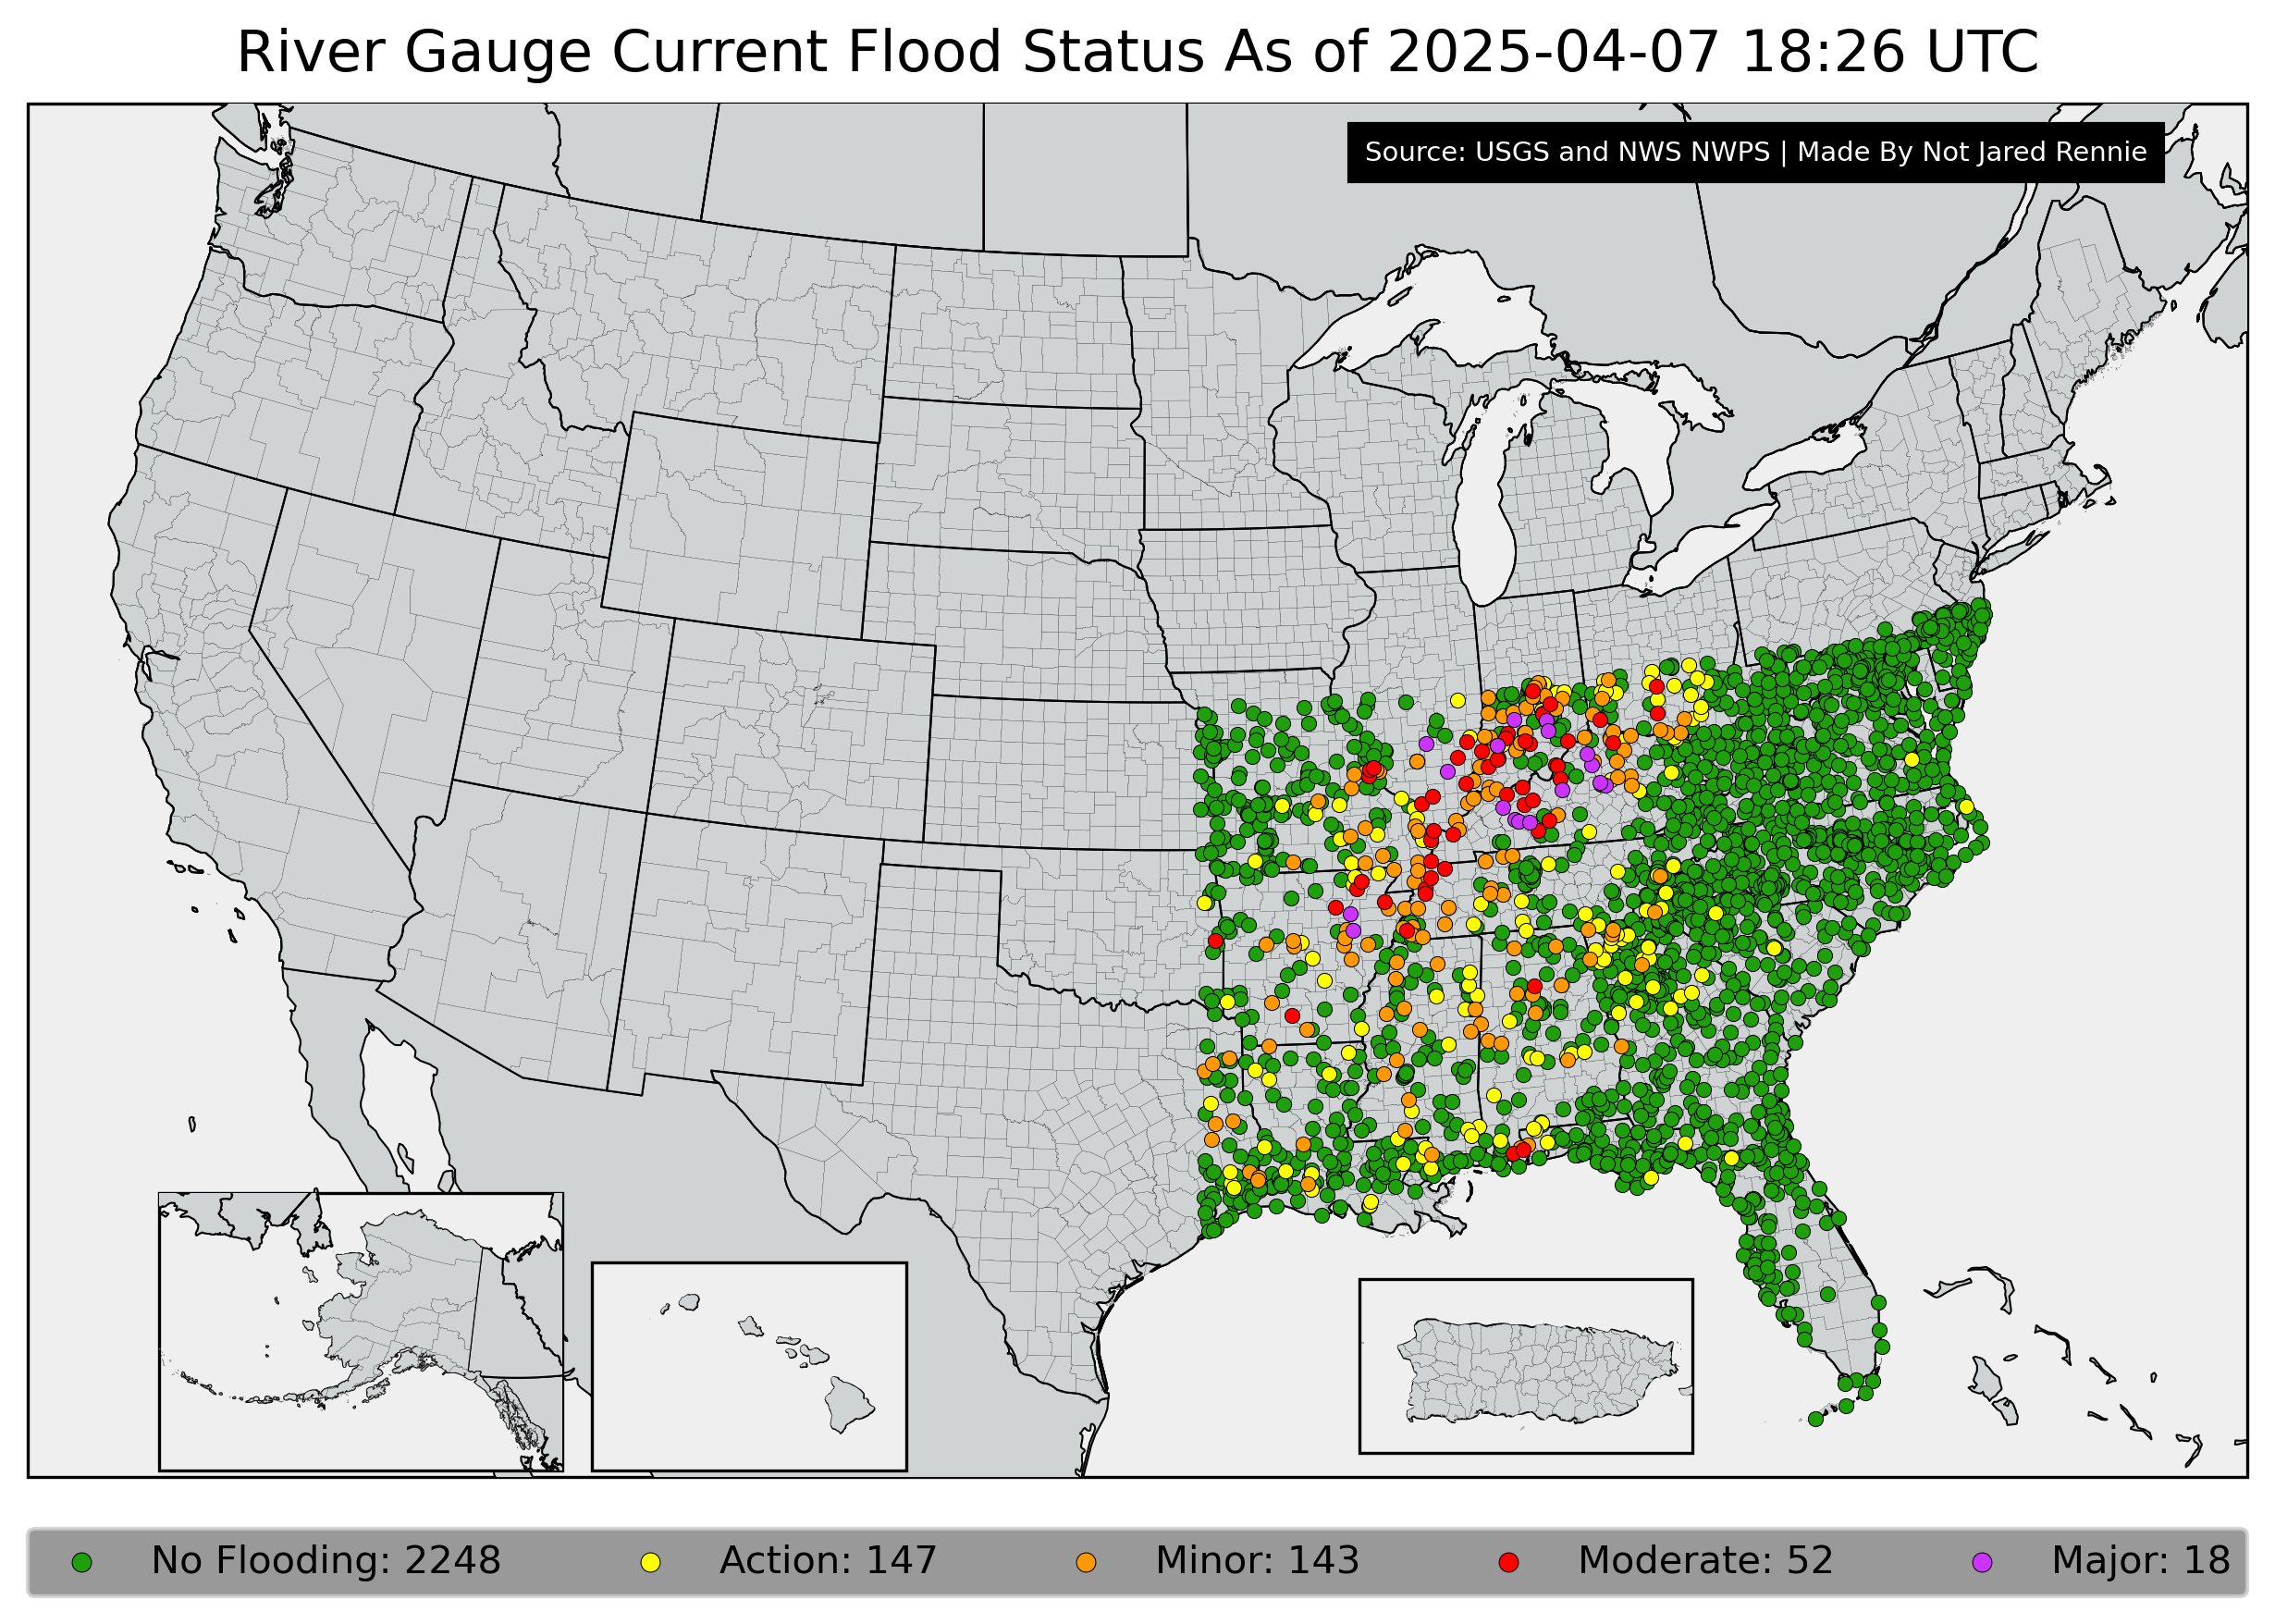

CPU times: user 2min 53s, sys: 1.03 s, total: 2min 54s
Wall time: 2min 58s


In [17]:
%%time
#################################################
# Plot All Stages (Observed)
print('PLOTTING OBSERVED STATUS')

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES

# Plotting Parameters
dpi=300
land_hex='#cfd3d4'  # ESRI Light Gray Canvas
ocean_hex='#efefef' # ESRI Light Gray Canvas
edgecolor='black'

# Set Up Figure
fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')

# CONUS AXES
conus_ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
conus_ax.set_facecolor(ocean_hex)
conus_ax.spines['geo'].set_edgecolor(edgecolor)
conus_ax.set_extent([-120, -73, 22, 50], crs=ccrs.Geodetic())

# ALASKA AXES
ak_ax = fig.add_axes([0.05, 0.01, 0.20, 0.20], projection=ccrs.Orthographic(central_longitude=-133.66666667, central_latitude=57.00000000))
ak_ax.set_facecolor(ocean_hex)
ak_ax.spines['geo'].set_edgecolor(edgecolor)
ak_ax.set_extent([-184, -128, 67, 53], crs=ccrs.Geodetic())

# HAWAII AXES
hi_ax = fig.add_axes([0.25, 0.01, 0.15, 0.15], projection=ccrs.Mercator())
hi_ax.set_facecolor(ocean_hex)
hi_ax.spines['geo'].set_edgecolor(edgecolor)
hi_ax.set_extent([-162, -154, 18, 23], crs=ccrs.Geodetic())

# PUERTO RICO AXES
pr_ax = fig.add_axes([0.60, 0.01, 0.15, 0.15], projection=ccrs.Mercator())
pr_ax.set_facecolor(ocean_hex)
pr_ax.spines['geo'].set_edgecolor(edgecolor)
pr_ax.set_extent([-67.5, -65.5, 17.75, 18.75], crs=ccrs.Geodetic())

# Add other Features
conus_ax.add_feature(cfeature.LAND,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=3)
conus_ax.add_feature(cfeature.LAKES,linewidth=0.5,facecolor=ocean_hex,edgecolor=edgecolor,zorder=4)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor=edgecolor,zorder=10)
conus_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

ak_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
ak_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

hi_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
hi_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

pr_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
pr_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

# Plot Points
stages=flood_categories
colors=['#1f9f0c','#feff03','#fe9804','#fe0200','#cc33ff']
totalFloody=0
color_counter=0
for stage in stages:
    floodyData=outData[outData['Flood Info'] ==stage]
    numFloody=len(floodyData['NWS ID'].unique())
    totalFloody=totalFloody+numFloody

    outLats=floodyData['Latitude'].values
    outLons=floodyData['Longitude'].values
    outStates=floodyData['State'].values
    outColor=colors[color_counter]

    # Add some dummy data (for labels)
    if stage == 'No_Flooding' or stage =='no_flooding':
        stage = 'No Flooding'
    conus_ax.scatter(0, 0, marker='o',s=25,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10,label=str(stage.title())+': '+str(numFloody))

    # Add Actual Data
    for counter in range(0,len(outLats)):
        lat=outLats[counter]
        lon=outLons[counter]
        st=outStates[counter].upper()
        if st =='AK':
            ak_ax.scatter(lon, lat, marker='o',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        elif st =='HI':
            hi_ax.scatter(lon, lat, marker='o',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        elif st == 'PR':
            pr_ax.scatter(lon, lat, marker='o',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        else:
            conus_ax.scatter(lon, lat, marker='o',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=100)
    color_counter+=1
    
# Add Legend
conus_ax.legend(bbox_to_anchor=(0., -.087, 1., -1.02), loc=3, ncol=5, mode="expand", borderaxespad=0., fontsize=10, facecolor='#808080')

# Add Titles
plt.suptitle('River Gauge Current Flood Status As of '+currTimeUTC,size=15,color='black',y=1.05) 
conus_ax.annotate('Source: USGS and NWS NWPS | Made By '+author,xy=(0.955, 0.955), xycoords='axes fraction', fontsize=7,backgroundcolor='black',color='white',horizontalalignment='right', verticalalignment='bottom',zorder=10)

# Show Plot
plt.show()

Cool, but this is observed, what is the forecast?

## Plot Forecast Station Status on a Map
Note that not all stations that observe flooding have forecasting info.

In [18]:
# Only Use Forecast Stations Reporting
flood_categories=['no_flooding','action','minor','moderate','major']
outDataFcst=outData[outData['Fcst Info'].isin(flood_categories)]

outDataFcst

NWS ID                                              Name State  \
2     ABBG1                       Ocmulgee River at Abbeville    GA   
5     ABDM6                  Buttahatchie River near Aberdeen    MS   
6     ABEM6          Tombigbee River at Aberdeen Lock and Dam    MS   
9     ABNG1                        Flint River (GA) at Albany    GA   
12    ABRW2                           Cheat River at Albright    WV   
...     ...                                               ...   ...   
4148  YLOG1  Yellow River at Pleasant Hill Road near Lithonia    GA   
4155  YWGM6                         Yalobusha River at Whaley    MS   
4156  YZOM6                         Yazoo River at Yazoo City    MS   
4157  ZANO1                     Muskingum River at Zanesville    OH   
4162  ZONI3                    Eagle Creek (IN) at Zionsville    IN   

       Latitude  Longitude    RFC  WFO  Gauge Height   Flood Info  \
2     31.996667 -83.279167  SERFC  FFC          5.96  no_flooding   
5     33.790000 -88.315278  SERFC  MEG         12.40       action   
6     33.830000 -88.520000  SERFC  MEG        170.81  no_flooding   
9     31.594167 -84.144167  SERFC  TAE          5.87  no_flooding   
12    39.494722 -79.644722  OHRFC  PBZ         15.02  no_flooding   
...         ...        ...    ...  ...           ...          ...   
4148  33.733611 -84.061944  SERFC  FFC          8.12  no_flooding   
4155  33.631400 -90.109100  LMRFC  JAN         21.60        minor   
4156  32.857900 -90.436800  LMRFC  JAN         25.09  no_flooding   
4157  39.938889 -82.012500  OHRFC  PBZ         18.04       action   
4162  39.946389 -86.260278  OHRFC  IND          3.57  no_flooding   

      Fcst Height    Fcst Info  
2            11.5       action  
5            15.7        minor  
6           170.8  no_flooding  
9            18.2       action  
12           16.1  no_flooding  
...           ...          ...  
4148         11.0       action  
4155         22.0        minor  
4156         27.8  no_flooding  
4157         18.9       action  
4162          3.3  no_flooding  

[788 rows x 11 columns]

PLOTTING FORECAST STATUS


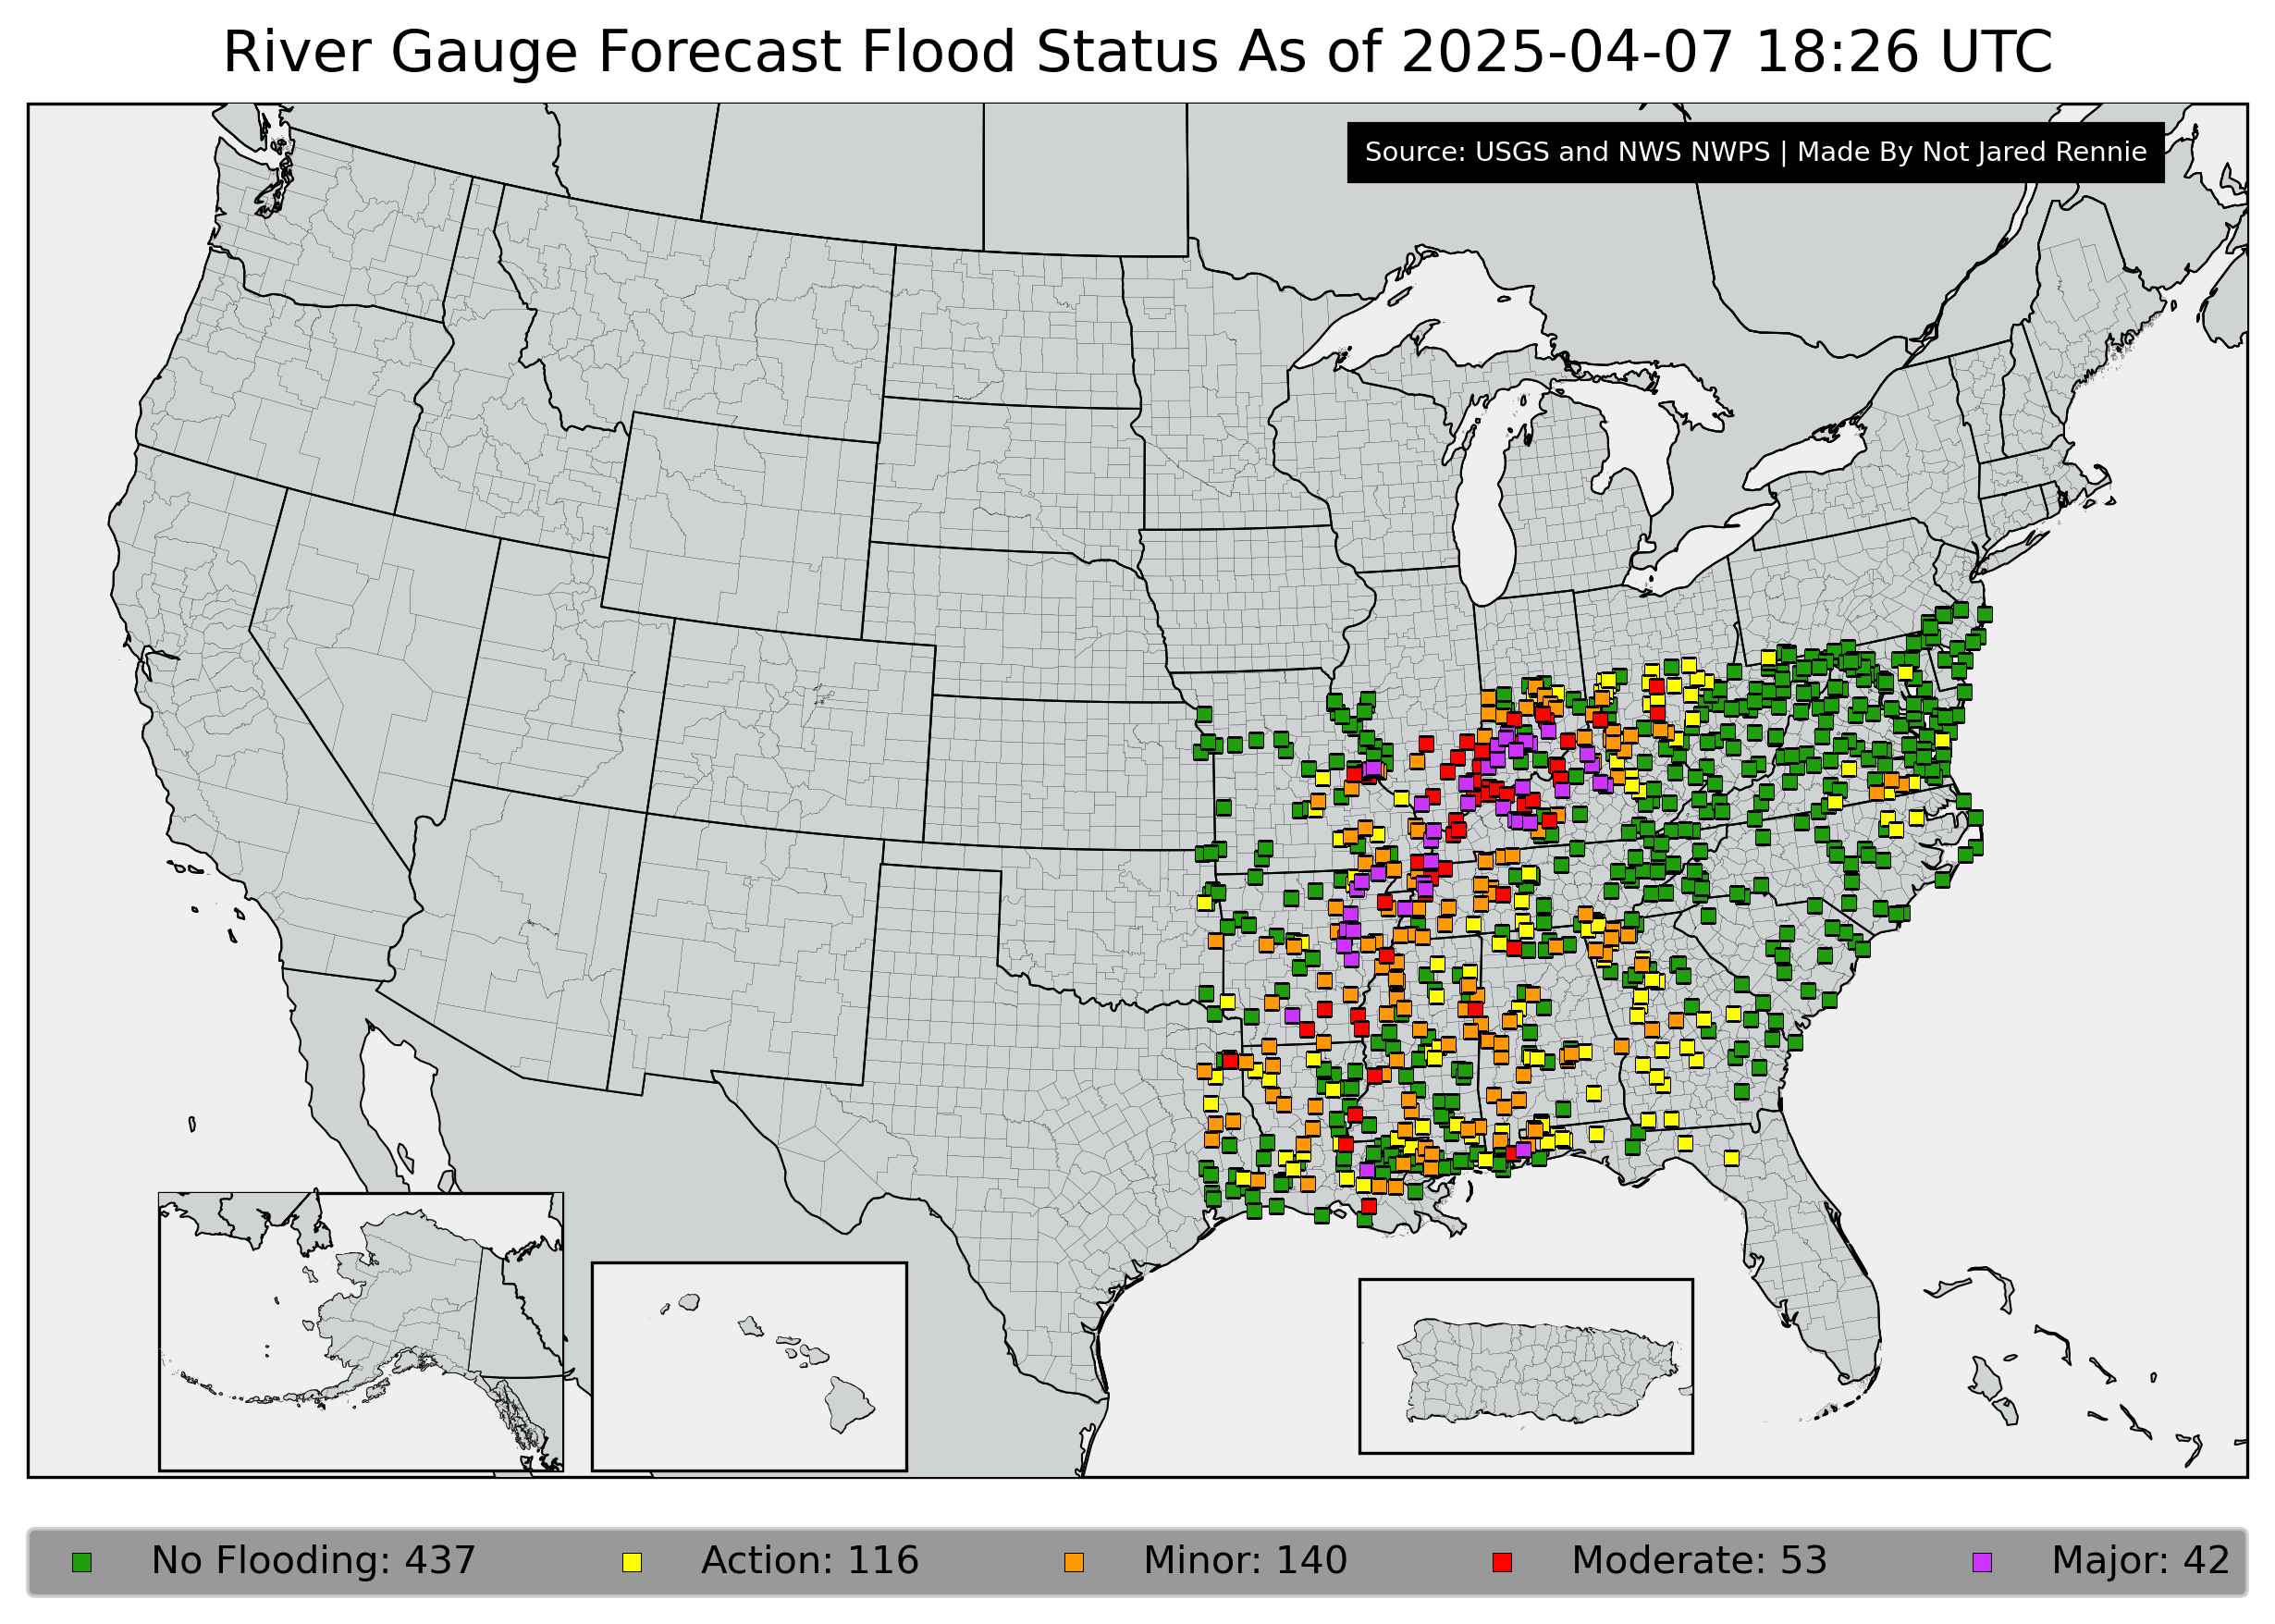

CPU times: user 2min 27s, sys: 229 ms, total: 2min 27s
Wall time: 2min 27s


In [19]:
%%time
#################################################
# Plot All Stages (Forecast)
print('PLOTTING FORECAST STATUS')

# Set Up Figure
fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')

# CONUS AXES
conus_ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
conus_ax.set_facecolor(ocean_hex)
conus_ax.spines['geo'].set_edgecolor(edgecolor)
conus_ax.set_extent([-120, -73, 22, 50], crs=ccrs.Geodetic())

# ALASKA AXES
ak_ax = fig.add_axes([0.05, 0.01, 0.20, 0.20], projection=ccrs.Orthographic(central_longitude=-133.66666667, central_latitude=57.00000000))
ak_ax.set_facecolor(ocean_hex)
ak_ax.spines['geo'].set_edgecolor(edgecolor)
ak_ax.set_extent([-184, -128, 67, 53], crs=ccrs.Geodetic())

# HAWAII AXES
hi_ax = fig.add_axes([0.25, 0.01, 0.15, 0.15], projection=ccrs.Mercator())
hi_ax.set_facecolor(ocean_hex)
hi_ax.spines['geo'].set_edgecolor(edgecolor)
hi_ax.set_extent([-162, -154, 18, 23], crs=ccrs.Geodetic())

# PUERTO RICO AXES
pr_ax = fig.add_axes([0.60, 0.01, 0.15, 0.15], projection=ccrs.Mercator())
pr_ax.set_facecolor(ocean_hex)
pr_ax.spines['geo'].set_edgecolor(edgecolor)
pr_ax.set_extent([-67.5, -65.5, 17.75, 18.75], crs=ccrs.Geodetic())

# Add other Features
conus_ax.add_feature(cfeature.LAND,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=3)
conus_ax.add_feature(cfeature.LAKES,linewidth=0.5,facecolor=ocean_hex,edgecolor=edgecolor,zorder=4)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor=edgecolor,zorder=10)
conus_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

ak_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
ak_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

hi_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
hi_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

pr_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
pr_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

# Plot Points
stages=flood_categories
colors=['#1f9f0c','#feff03','#fe9804','#fe0200','#cc33ff']
totalFloody=0
color_counter=0
for stage in stages:
    floodyData=outDataFcst[outDataFcst['Fcst Info'] ==stage]
    numFloody=len(floodyData['NWS ID'].unique())
    totalFloody=totalFloody+numFloody

    outLats=floodyData['Latitude'].values
    outLons=floodyData['Longitude'].values
    outStates=floodyData['State'].values
    outColor=colors[color_counter]

    # Add some dummy data (for labels)
    if stage == 'No_Flooding' or stage =='no_flooding':
        stage = 'No Flooding'
    conus_ax.scatter(0, 0, marker='s',s=25,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10,label=str(stage.title())+': '+str(numFloody))

    # Add Actual Data
    for counter in range(0,len(outLats)):
        lat=outLats[counter]
        lon=outLons[counter]
        st=outStates[counter].upper()
        if st =='AK':
            ak_ax.scatter(lon, lat, marker='s',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        elif st =='HI':
            hi_ax.scatter(lon, lat, marker='s',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        elif st == 'PR':
            pr_ax.scatter(lon, lat, marker='s',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        else:
            conus_ax.scatter(lon, lat, marker='s',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=100)
    color_counter+=1
    
# Add Legend
conus_ax.legend(bbox_to_anchor=(0., -.087, 1., -1.02), loc=3, ncol=5, mode="expand", borderaxespad=0., fontsize=10, facecolor='#808080')

# Add Titles
plt.suptitle('River Gauge Forecast Flood Status As of '+currTimeUTC,size=15,color='black',y=1.05) 
conus_ax.annotate('Source: USGS and NWS NWPS | Made By '+author,xy=(0.955, 0.955), xycoords='axes fraction', fontsize=7,backgroundcolor='black',color='white',horizontalalignment='right', verticalalignment='bottom',zorder=10)

# Show Plot
plt.show()

Isn't it beautiful? Congrats! You made a spatial plot! Feel free to post on social media for the world to see!

Congrats on completing this notebook! Now go forth and make better plots!

# BONUS: Record Crest Observations and Forecast
Depending on the situation, it might be useful to see if stations are currently at or forecasted to be above or close to historic crests. The initial multidata call does not have record crest information, so we will have to look at each station individually. Run a loop below and add it to the pandas dataframe.

**WARNING: This may take some time, depending on how many stations are being called.**

In [28]:
%%time

# Add Two New Columns
outData = outData.copy()
outData['Record Height'] = -9999.
outData['Record Info'] = '-9999'

# Run through station and use API to get Record Height Information
for index, row in outData.iterrows():
    nwsID=row['NWS ID']

    # Insert Dummy Variables
    recordTime='-9999'
    recordVal=-9999.
    
    # API URL (Metadata)
    url = "https://api.water.noaa.gov/nwps/v1/gauges/"+nwsID

    # Make the request
    response = requests.get(url)

    # Check if request was successful
    if response.status_code == 200:
        jsonData = response.json()  # Convert response to JSON

        # Record Time and Record Val might not be availale, so do a quick check here
        try:
            recordTime=jsonData["flood"]["crests"]["historic"][0].get("occurredTime")
            recordVal=jsonData["flood"]["crests"]["historic"][0].get("stage")
        except:
            pass
    outData.at[index,'Record Height']=recordVal
    outData.at[index,'Record Info']=recordTime
outData

NWS ID                                               Name State  \
0     AANG1                         Peachtree Creek at Atlanta    GA   
1     ABAG1    Alabaha River at GA Highway 203 near Blackshear    GA   
2     ABBG1                        Ocmulgee River at Abbeville    GA   
3     ABBN7                       Abbotts Creek near Lexington    NC   
5     ABDM6                   Buttahatchie River near Aberdeen    MS   
...     ...                                                ...   ...   
4161  ZFSF1                       Peace River at Zolfo Springs    FL   
4162  ZONI3                     Eagle Creek (IN) at Zionsville    IN   
4163  ZPHF1  Hillsborough River near Zephyrhills at State Park    FL   
4164  ZSRM2                      Zekiah Swamp Run near Newtown    MD   
4166  ZUNV2                    Blackwater River (VA) near ZUNI    VA   

       Latitude  Longitude    RFC  WFO  Gauge Height   Flood Info  \
0     33.820306 -84.407639  SERFC  FFC          6.66  no_flooding   
1     31.375278 -82.288889  SERFC  JAX          5.92  no_flooding   
2     31.996667 -83.279167  SERFC  FFC          5.96  no_flooding   
3     35.806944 -80.234722  SERFC  RAH          4.03  no_flooding   
5     33.790000 -88.315278  SERFC  MEG         12.40       action   
...         ...        ...    ...  ...           ...          ...   
4161  27.504167 -81.801111  SERFC  TBW          4.17  no_flooding   
4162  39.946389 -86.260278  OHRFC  IND          3.57  no_flooding   
4163  28.149722 -82.231944  SERFC  TBW          1.08  no_flooding   
4164  38.490556 -76.927222  MARFC  LWX          2.05  no_flooding   
4166  36.906389 -76.820278  SERFC  AKQ         18.01  no_flooding   

      Fcst Height         Fcst Info  Record Height           Record Info  
0          -999.0  fcst_not_current          25.80  1919-12-09T00:00:00Z  
1          -999.0  fcst_not_current          15.60  1948-04-05T00:00:00Z  
2            11.5            action          23.10  1994-07-11T00:00:00Z  
3          -999.0  fcst_not_current          23.48  2003-09-23T00:00:00Z  
5            15.7             minor          23.48  1973-03-17T00:00:00Z  
...           ...               ...            ...                   ...  
4161       -999.0  fcst_not_current          27.24  2022-09-29T21:30:00Z  
4162          3.3       no_flooding          19.20  1957-06-28T00:00:00Z  
4163       -999.0  fcst_not_current          17.14  2024-10-11T04:15:00Z  
4164       -999.0  fcst_not_current           6.81  2011-09-08T14:00:00Z  
4166       -999.0  fcst_not_current          25.14  2020-09-20T01:30:00Z  

[2608 rows x 13 columns]

Do a little cleaning up to remove missing values, then calculate the difference between record height and current observed height. 

In [63]:
# Cleanup and Get Difference
outData=outData[outData['Gauge Height'] > -990.]
outData=outData[outData['Record Height'] > -990.]
outData['obsDIFF'] = outData['Record Height']- outData['Gauge Height']
outData

NWS ID                                              Name State  \
2     ABBG1                       Ocmulgee River at Abbeville    GA   
5     ABDM6                  Buttahatchie River near Aberdeen    MS   
6     ABEM6          Tombigbee River at Aberdeen Lock and Dam    MS   
9     ABNG1                        Flint River (GA) at Albany    GA   
12    ABRW2                           Cheat River at Albright    WV   
...     ...                                               ...   ...   
4148  YLOG1  Yellow River at Pleasant Hill Road near Lithonia    GA   
4155  YWGM6                         Yalobusha River at Whaley    MS   
4156  YZOM6                         Yazoo River at Yazoo City    MS   
4157  ZANO1                     Muskingum River at Zanesville    OH   
4162  ZONI3                    Eagle Creek (IN) at Zionsville    IN   

       Latitude  Longitude    RFC  WFO  Gauge Height   Flood Info  \
2     31.996667 -83.279167  SERFC  FFC          5.96  no_flooding   
5     33.790000 -88.315278  SERFC  MEG         12.40       action   
6     33.830000 -88.520000  SERFC  MEG        170.81  no_flooding   
9     31.594167 -84.144167  SERFC  TAE          5.87  no_flooding   
12    39.494722 -79.644722  OHRFC  PBZ         15.02  no_flooding   
...         ...        ...    ...  ...           ...          ...   
4148  33.733611 -84.061944  SERFC  FFC          8.12  no_flooding   
4155  33.631400 -90.109100  LMRFC  JAN         21.60        minor   
4156  32.857900 -90.436800  LMRFC  JAN         25.09  no_flooding   
4157  39.938889 -82.012500  OHRFC  PBZ         18.04       action   
4162  39.946389 -86.260278  OHRFC  IND          3.57  no_flooding   

      Fcst Height    Fcst Info  Record Height           Record Info   DIFF  \
2            11.5       action          23.10  1994-07-11T00:00:00Z  17.14   
5            15.7        minor          23.48  1973-03-17T00:00:00Z  11.08   
6           170.8  no_flooding         189.50  1982-12-28T00:00:00Z  18.69   
9            18.2       action          43.00  1994-07-11T00:00:00Z  37.13   
12           16.1  no_flooding          27.23  2017-07-29T23:00:00Z  12.21   
...           ...          ...            ...                   ...    ...   
4148         11.0       action          25.54  2009-09-22T10:00:00Z  17.42   
4155         22.0        minor          27.79  1948-02-18T00:00:00Z   6.19   
4156         27.8  no_flooding          43.40  1927-05-05T00:00:00Z  18.31   
4157         18.9       action          51.80  1913-03-27T00:00:00Z  33.76   
4162          3.3  no_flooding          19.20  1957-06-28T00:00:00Z  15.63   

      obsDIFF  
2       17.14  
5       11.08  
6       18.69  
9       37.13  
12      12.21  
...       ...  
4148    17.42  
4155     6.19  
4156    18.31  
4157    33.76  
4162    15.63  

[771 rows x 15 columns]

Now find stations that tied or broke the record (if any)

In [64]:
# Find Times where observed value is greater than or equal to the record
obsRecord=outData[outData['Gauge Height'] >= outData['Record Height']]
obsRecord

NWS ID                                Name State   Latitude  Longitude  \
481   BRRK2   Barren River at Barren River Lake    KY  36.891944 -86.124167   
2445  MMCK2  Green River (KY) near Mammoth Cave    KY  37.180000 -86.112500   
2758  OBNT1              Obion River near Obion    TN  36.240760 -89.217575   
3256  RRLK2     Rough River at Rough River Lake    KY  37.620000 -86.499444   

        RFC  WFO  Gauge Height   Flood Info  Fcst Height    Fcst Info  \
481   OHRFC  LMK        583.98  no_flooding       585.69  no_flooding   
2445  OHRFC  LMK         57.93     moderate        57.50     moderate   
2758  LMRFC  MEG         40.55     moderate        40.90     moderate   
3256  OHRFC  LMK        530.16     moderate       530.02     moderate   

      Record Height           Record Info  DIFF  obsDIFF  
481           583.0  1989-03-08T23:00:00Z -0.98    -0.98  
2445           52.0  1937-01-24T00:00:00Z -5.93    -5.93  
2758           40.4  1937-01-24T00:00:00Z -0.15    -0.15  
3256          527.3  2011-05-04T12:00:00Z -2.86    -2.86

What about times where it's not at the record but really close? Let's define that as 1 foot.

In [65]:
# Find times where observed value is within a threshold of the record.
closeThresh=1.
obsClose = outData[(outData['obsDIFF'] <= closeThresh) & (outData['obsDIFF'] > 0)]
obsClose

NWS ID                              Name State   Latitude  Longitude  \
1344  FFTK2  Kentucky River at Frankfort Lock    KY  38.201667 -84.881667   
1679  HENK2           Ohio River at Henderson    KY  37.845556 -87.592222   

        RFC  WFO  Gauge Height Flood Info  Fcst Height Fcst Info  \
1344  OHRFC  LMK         48.13      major         47.9     major   
1679  OHRFC  PAH         38.63      minor         43.3  moderate   

      Record Height           Record Info  DIFF  obsDIFF  
1344          48.47  1978-12-10T18:38:00Z  0.34     0.34  
1679          39.59  2025-02-23T04:30:00Z  0.96     0.96

Now let's see if it's forecasted to be close to, or above the record.

In [68]:
# Cleanup and Get Difference
outData=outData[outData['Fcst Height'] > -990.]
outData=outData[outData['Record Height'] > -990.]
outData['fcstDIFF'] = outData['Record Height']- outData['Fcst Height']

# Find Times where forecast value is greater than or equal to the record
fcstRecord=outData[outData['Fcst Height'] >= outData['Record Height']]
fcstRecord

NWS ID                                          Name State   Latitude  \
481   BRRK2             Barren River at Barren River Lake    KY  36.891944   
1679  HENK2                       Ohio River at Henderson    KY  37.845556   
2445  MMCK2            Green River (KY) near Mammoth Cave    KY  37.180000   
2758  OBNT1                        Obion River near Obion    TN  36.240760   
2792  OLMI2  Ohio River at Olmsted Lock and Dam Headwater    IL  37.179167   
3256  RRLK2               Rough River at Rough River Lake    KY  37.620000   

      Longitude    RFC  WFO  Gauge Height   Flood Info  Fcst Height  \
481  -86.124167  OHRFC  LMK        583.98  no_flooding       585.69   
1679 -87.592222  OHRFC  PAH         38.63        minor        43.30   
2445 -86.112500  OHRFC  LMK         57.93     moderate        57.50   
2758 -89.217575  LMRFC  MEG         40.55     moderate        40.90   
2792 -89.058333  LMRFC  PAH         46.20     moderate        50.00   
3256 -86.499444  OHRFC  LMK        530.16     moderate       530.02   

        Fcst Info  Record Height           Record Info  DIFF  obsDIFF  \
481   no_flooding         583.00  1989-03-08T23:00:00Z -0.98    -0.98   
1679     moderate          39.59  2025-02-23T04:30:00Z  0.96     0.96   
2445     moderate          52.00  1937-01-24T00:00:00Z -5.93    -5.93   
2758     moderate          40.40  1937-01-24T00:00:00Z -0.15    -0.15   
2792        major          48.20  2020-02-21T15:00:00Z  2.00     2.00   
3256     moderate         527.30  2011-05-04T12:00:00Z -2.86    -2.86   

      fcstDIFF  
481      -2.69  
1679     -3.71  
2445     -5.50  
2758     -0.50  
2792     -1.80  
3256     -2.72

In [69]:
# Find times where forecast value is within a threshold of the record.
closeThresh=1.
fcstClose = outData[(outData['fcstDIFF'] <= closeThresh) & (outData['fcstDIFF'] > 0)]
fcstClose

NWS ID                              Name State   Latitude  Longitude  \
943   CRLK2    Licking River at Cave Run Lake    KY  38.117528 -83.532145   
1344  FFTK2  Kentucky River at Frankfort Lock    KY  38.201667 -84.881667   
3020  PRDK2      Green River (KY) at Paradise    KY  37.263889 -86.977778   

        RFC  WFO  Gauge Height   Flood Info  Fcst Height    Fcst Info  \
943   OHRFC  JKL        755.00  no_flooding       758.79  no_flooding   
1344  OHRFC  LMK         48.13        major        47.90        major   
3020  OHRFC  PAH        401.82        major       403.40        major   

      Record Height           Record Info  DIFF  obsDIFF  fcstDIFF  
943          759.70  2011-05-05T00:00:00Z  4.70     4.70      0.91  
1344          48.47  1978-12-10T18:38:00Z  0.34     0.34      0.57  
3020         403.65  1962-03-05T00:00:00Z  1.83     1.83      0.25

Now Plot Everything! Adjust Colors as Needed

PLOTTING OBSERVED STATUS (WITH RECORDS)


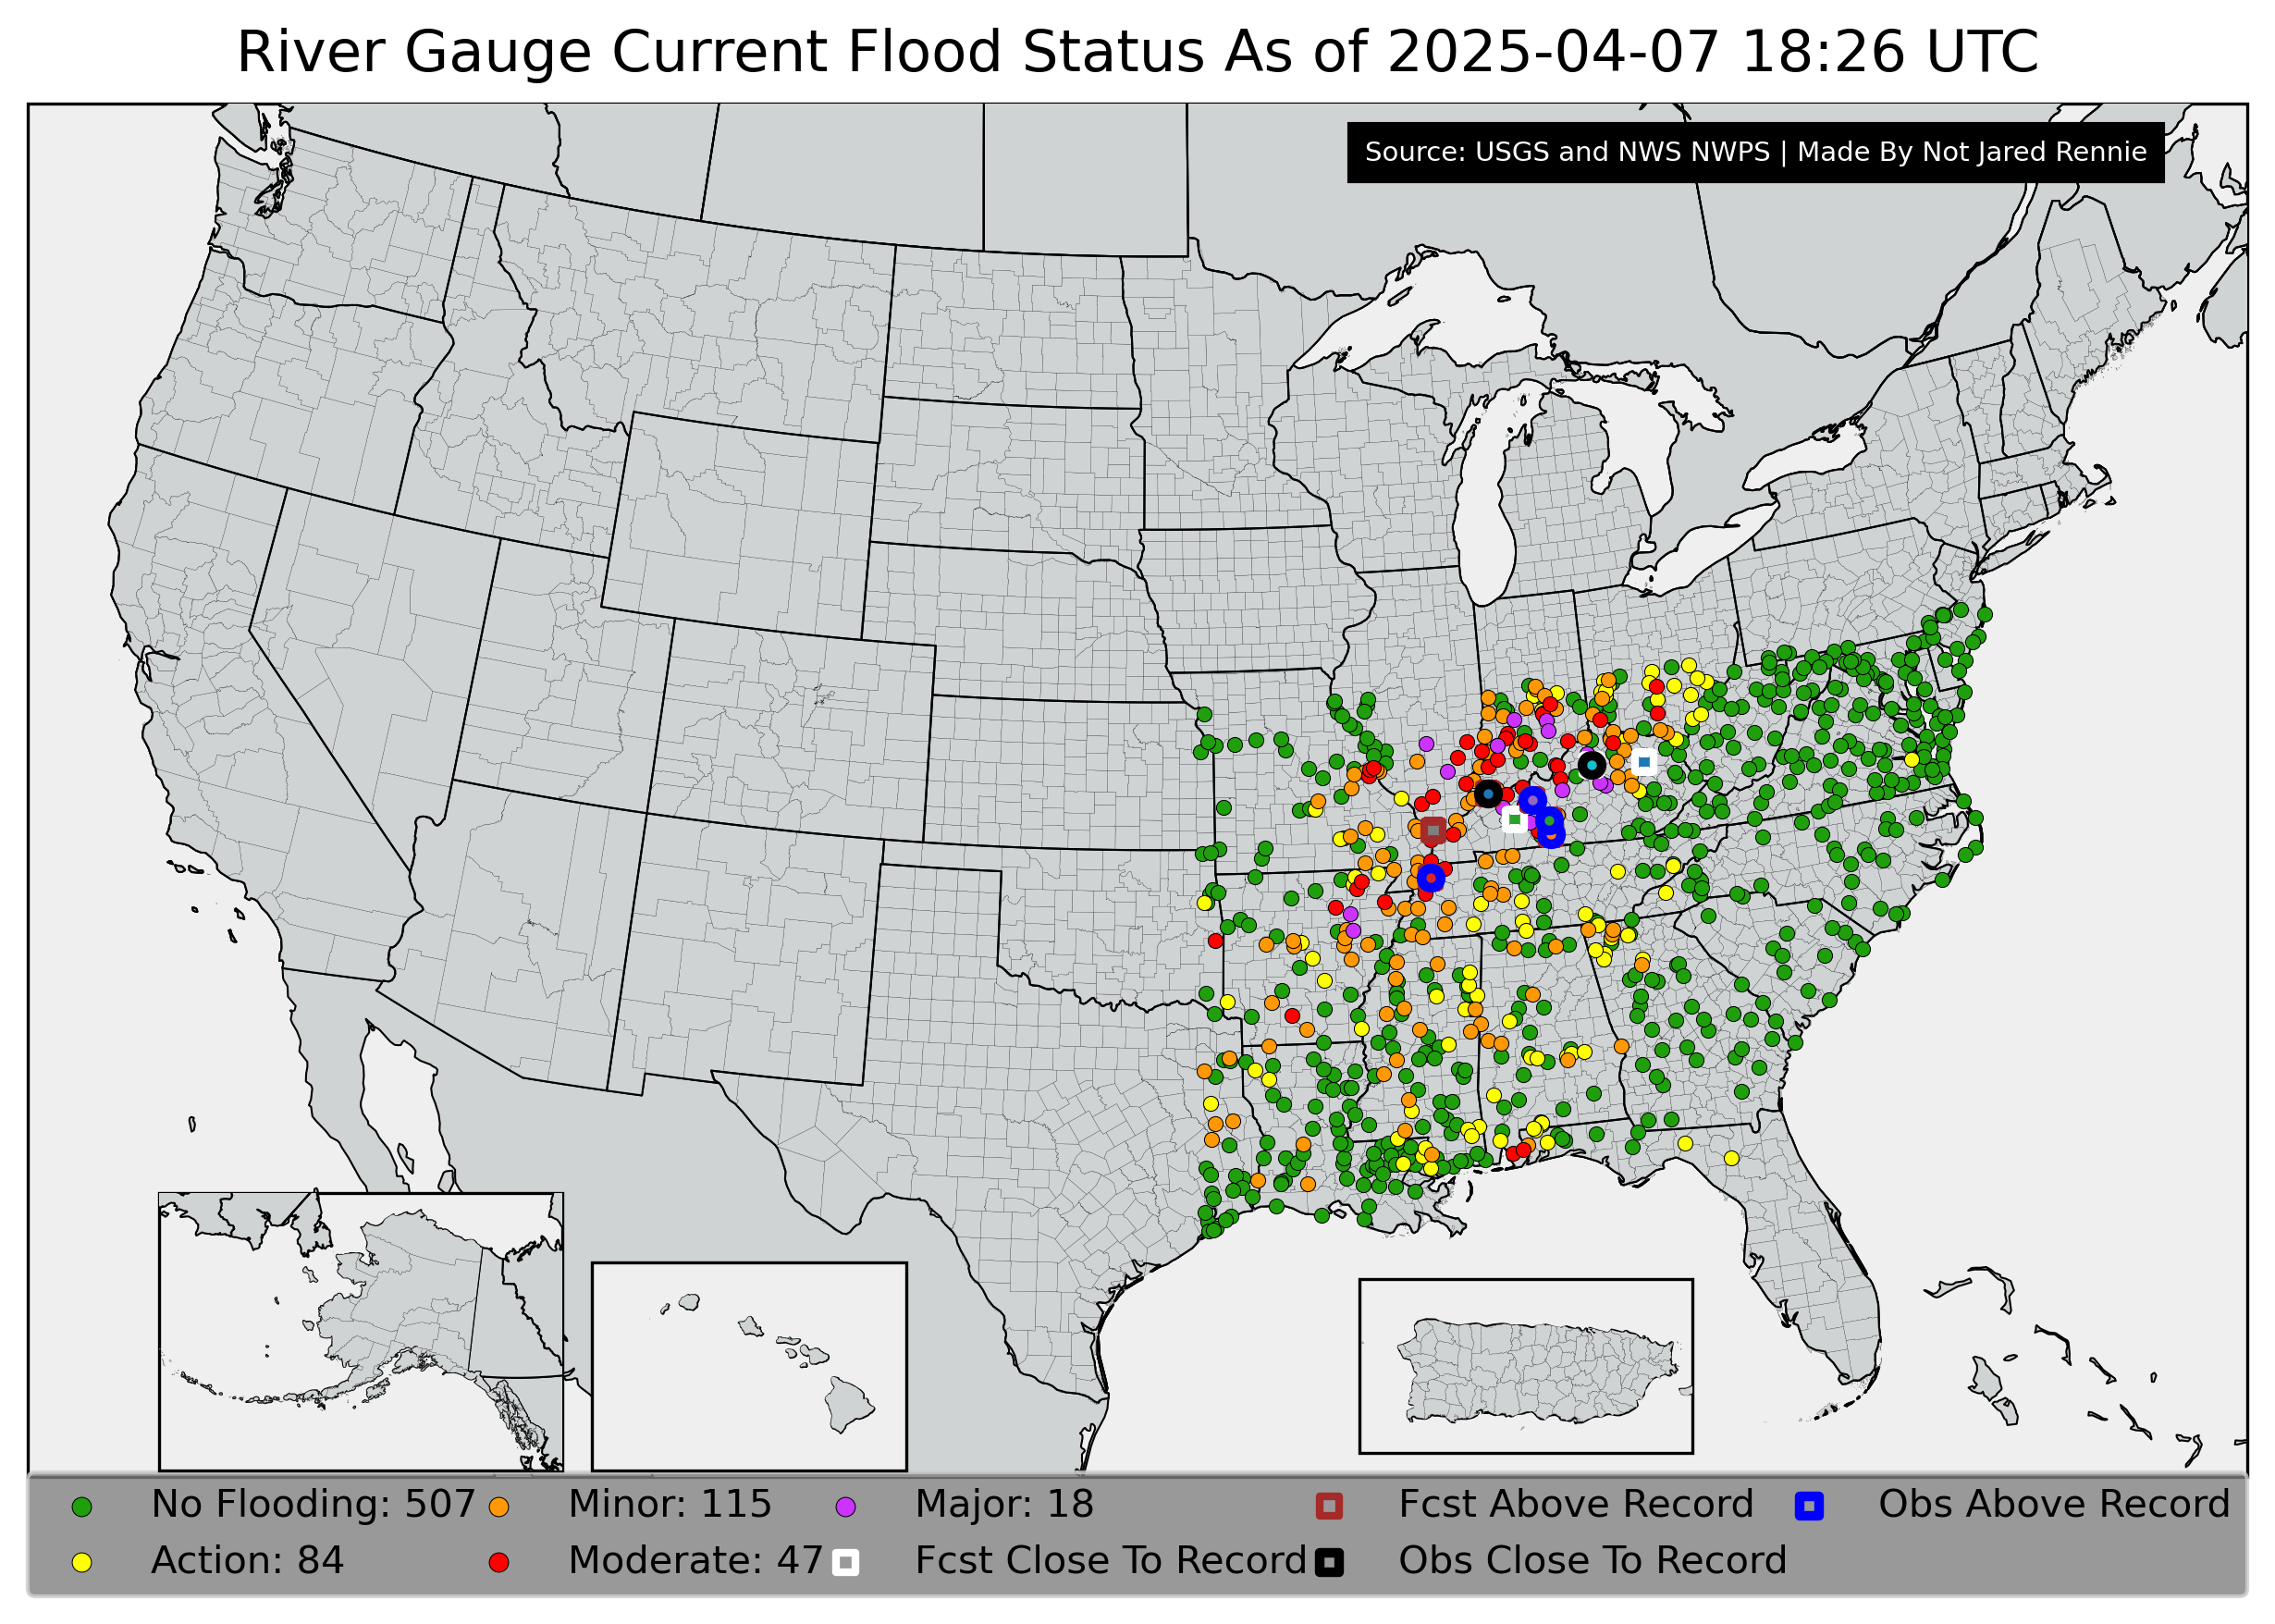

CPU times: user 2min 32s, sys: 270 ms, total: 2min 32s
Wall time: 2min 32s


In [74]:
%%time
#################################################
# Plot 
print('PLOTTING OBSERVED STATUS (WITH RECORDS)')

# Set Up Figure
fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')

# CONUS AXES
conus_ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
conus_ax.set_facecolor(ocean_hex)
conus_ax.spines['geo'].set_edgecolor(edgecolor)
conus_ax.set_extent([-120, -73, 22, 50], crs=ccrs.Geodetic())

# ALASKA AXES
ak_ax = fig.add_axes([0.05, 0.01, 0.20, 0.20], projection=ccrs.Orthographic(central_longitude=-133.66666667, central_latitude=57.00000000))
ak_ax.set_facecolor(ocean_hex)
ak_ax.spines['geo'].set_edgecolor(edgecolor)
ak_ax.set_extent([-184, -128, 67, 53], crs=ccrs.Geodetic())

# HAWAII AXES
hi_ax = fig.add_axes([0.25, 0.01, 0.15, 0.15], projection=ccrs.Mercator())
hi_ax.set_facecolor(ocean_hex)
hi_ax.spines['geo'].set_edgecolor(edgecolor)
hi_ax.set_extent([-162, -154, 18, 23], crs=ccrs.Geodetic())

# PUERTO RICO AXES
pr_ax = fig.add_axes([0.60, 0.01, 0.15, 0.15], projection=ccrs.Mercator())
pr_ax.set_facecolor(ocean_hex)
pr_ax.spines['geo'].set_edgecolor(edgecolor)
pr_ax.set_extent([-67.5, -65.5, 17.75, 18.75], crs=ccrs.Geodetic())

# Add other Features
conus_ax.add_feature(cfeature.LAND,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=3)
conus_ax.add_feature(cfeature.LAKES,linewidth=0.5,facecolor=ocean_hex,edgecolor=edgecolor,zorder=4)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor=edgecolor,zorder=10)
conus_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

ak_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
ak_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

hi_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
hi_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

pr_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
pr_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

# Plot Points
stages=flood_categories
colors=['#1f9f0c','#feff03','#fe9804','#fe0200','#cc33ff']
totalFloody=0
color_counter=0
for stage in stages:
    floodyData=outData[outData['Flood Info'] ==stage]
    numFloody=len(floodyData['NWS ID'].unique())
    totalFloody=totalFloody+numFloody

    outLats=floodyData['Latitude'].values
    outLons=floodyData['Longitude'].values
    outStates=floodyData['State'].values
    outColor=colors[color_counter]

    # Add some dummy data (for labels)
    if stage == 'No_Flooding' or stage =='no_flooding':
        stage = 'No Flooding'
    conus_ax.scatter(0, 0, marker='o',s=25,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10,label=str(stage.title())+': '+str(numFloody))

    # Add Actual Data
    for counter in range(0,len(outLats)):
        lat=outLats[counter]
        lon=outLons[counter]
        st=outStates[counter].upper()
        if st =='AK':
            ak_ax.scatter(lon, lat, marker='o',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        elif st =='HI':
            hi_ax.scatter(lon, lat, marker='o',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        elif st == 'PR':
            pr_ax.scatter(lon, lat, marker='o',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        else:
            conus_ax.scatter(lon, lat, marker='o',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=95)
    color_counter+=1

# Plot fcstClose
outLats=fcstClose['Latitude'].values
outLons=fcstClose['Longitude'].values
conus_ax.scatter(0, 0, marker='s',s=25,color='None',edgecolors='white',linewidths=2.00,transform=ccrs.PlateCarree(),zorder=96,label='Fcst Close To Record')
for counter in range(0,len(outLats)):
    lat=outLats[counter]
    lon=outLons[counter]
    conus_ax.scatter(lon, lat, marker='s',s=25,edgecolors='white',linewidths=2.00,transform=ccrs.PlateCarree(),zorder=96)

# Plot fcstRecord
outLats=fcstRecord['Latitude'].values
outLons=fcstRecord['Longitude'].values
conus_ax.scatter(0, 0, marker='s',s=25,color='None',edgecolors='brown',linewidths=2.00,transform=ccrs.PlateCarree(),zorder=97,label='Fcst Above Record')
for counter in range(0,len(outLats)):
    lat=outLats[counter]
    lon=outLons[counter]
    conus_ax.scatter(lon, lat, marker='s',s=25,edgecolors='brown',linewidths=2.00,transform=ccrs.PlateCarree(),zorder=97)

# Plot obsClose
outLats=obsClose['Latitude'].values
outLons=obsClose['Longitude'].values
conus_ax.scatter(0, 0, marker='s',s=25,color='None',edgecolors='black',linewidths=2.50,transform=ccrs.PlateCarree(),zorder=98,label='Obs Close To Record')
for counter in range(0,len(outLats)):
    lat=outLats[counter]
    lon=outLons[counter]
    conus_ax.scatter(lon, lat, marker='o',s=25,edgecolors='black',linewidths=2.50,transform=ccrs.PlateCarree(),zorder=98)

# Plot obsRecord
outLats=obsRecord['Latitude'].values
outLons=obsRecord['Longitude'].values
conus_ax.scatter(0, 0, marker='s',s=25,color='None',edgecolors='blue',linewidths=2.50,transform=ccrs.PlateCarree(),zorder=99,label='Obs Above Record')
for counter in range(0,len(outLats)):
    lat=outLats[counter]
    lon=outLons[counter]
    conus_ax.scatter(lon, lat, marker='o',s=25,edgecolors='blue',linewidths=2.50,transform=ccrs.PlateCarree(),zorder=99)

# Add Legend
conus_ax.legend(bbox_to_anchor=(0., -.087, 1., -1.02), loc=3, ncol=5, mode="expand", borderaxespad=0., fontsize=10, facecolor='#808080')

# Add Titles
plt.suptitle('River Gauge Current Flood Status As of '+currTimeUTC,size=15,color='black',y=1.05) 
conus_ax.annotate('Source: USGS and NWS NWPS | Made By '+author,xy=(0.955, 0.955), xycoords='axes fraction', fontsize=7,backgroundcolor='black',color='white',horizontalalignment='right', verticalalignment='bottom',zorder=10)

# Show Plot
plt.show()